✓ Imports OK
✓ Config loaded

=== LOAD & PREP ===
--- Train Fixed shape=(46129, 24)
              timestamp  devID     soil  rain      temp      humi  geo  rain_ma_1h  rain_ma_6h  rain_ma_12h  rain_ma_24h  rain_ma_1h  rain_ma_6h  rain_ma_12h  rain_ma_24h  soil_ma_4h  soil_ma_8h  soil_ma_12h  soil_ma_16h  geo_ma_2min  geo_ma_4min  geo_ma_6min  geo_ma_8min label
2025-11-01 06:33:49.988    108 0.000000   0.0 34.000000 66.500000  0.0         0.0         0.0          0.0          0.0         0.0         0.0          0.0          0.0    0.000000    0.000000     0.000000     0.000000          0.0          0.0          0.0          0.0   NaN
2025-11-01 06:34:28.395    108 0.000000   0.0 34.000000 66.500000  0.0         0.0         0.0          0.0          0.0         0.0         0.0          0.0          0.0    0.000000    0.000000     0.000000     0.000000          0.0          0.0          0.0          0.0   NaN
2025-11-01 06:35:13.489    108 0.798555   0.0 34.049999 66.650002  0.0         

<Figure size 1000x600 with 0 Axes>

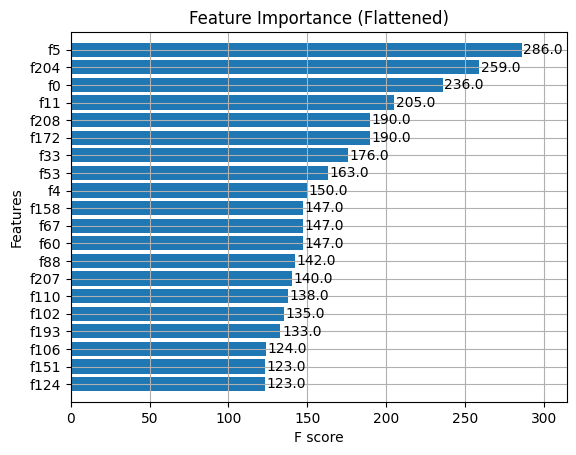

In [2]:
# %%
"""
=========================================================================================
PROJECT: LANDSLIDE DETECTION XGBOOST (Standard / No Threshold)
โครงการ: ระบบตรวจจับดินถล่มด้วย XGBoost (แบบมาตรฐาน ไม่กำหนด Threshold)
=========================================================================================

[KEY FEATURES]
1. Model: XGBoost Classifier (Gradient Boosting Tree)
2. Data Shape: Flattened (Samples, 150) from (Samples, 30, 5)
3. Decision: Standard Argmax (Highest Probability Wins)
4. Balance: Hybrid Resampling (Normal=Warning=Critical)

=========================================================================================
"""

# %%
# ====================================================================
# CELL 1: IMPORTS & CONFIG
# ====================================================================
import re
import os
import random
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')
print("✓ Imports OK")

class Config:
    TRAIN_PATH = "../../data/final_label_data_training_moving_avg.csv"
    VAL_PATH   = "../../data/final_moving_avg_devID109_rain_6_hour.csv"
    
    # Optional Pretrained Feature Models
    AE_MODEL_PATH = "./../LSTM_Autoencoders/lstm_autoencoder_model_fit.h5"
    AE_SCALER_PATH = "./../LSTM_Autoencoders/scaler_fit.save"
    ISO_SCALER_PATH = "./../IsalationForest/model/iso_scaler.joblib"
    ISO_MODEL_PATH = "./../IsalationForest/model/iso_model.joblib"
    
    OUTPUT_MODEL = "xgboost_standard.json"
    OUTPUT_SCALER = "scaler_xgb_std.save"
    
    NUMERIC_COLS = ['soil','rain','temp','humi','geo']
    LABEL_COL = 'label'
    LABEL_MAP = {'normal':0, 'warning':1, 'critical':2}
    
    SEQUENCE_LENGTH = 30
    TRAIN_DEV_RATIO = 0.9
    RANDOM_SEED = 42
    
    # XGBoost Hyperparameters
    XGB_PARAMS = {
        'n_estimators': 500,
        'learning_rate': 0.05,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'objective': 'multi:softprob', 
        'num_class': 3,
        'n_jobs': -1,
        'random_state': 42
    }
    
cfg = Config()
np.random.seed(cfg.RANDOM_SEED); random.seed(cfg.RANDOM_SEED)
print("✓ Config loaded")

# %%
# ====================================================================
# CELL 2: UTILITIES
# ====================================================================
def normalize_and_map_columns(df):
    df = df.copy()
    df.columns = [str(c).lower().strip().replace('.1', '') for c in df.columns]
    rename_map = {
        'temperature':'temp','temp':'temp', 'hum':'humi','humidity':'humi','humi':'humi',
        'devid':'devID','deviceid':'devID','device_id':'devID','device':'devID','node':'devID',
        'time':'timestamp','timestamp':'timestamp','date':'timestamp'
    }
    new_cols = {c: rename_map[c] for c in df.columns if c in rename_map}
    if new_cols: df = df.rename(columns=new_cols)
    return df

def parse_timestamp_series(s):
    return pd.to_datetime(s, errors='coerce', infer_datetime_format=True)

def normalize_dev_id_series(s):
    def to_id(x):
        if pd.isna(x): return x
        s_val = str(x).strip()
        m = re.search(r'(\d+)', s_val)
        if m: return int(m.group(1))
        return s_val
    return s.apply(to_id)

def show_head(df, name="df"):
    print(f"--- {name} shape={df.shape}")
    if not df.empty: print(df.head(3).to_string(index=False))

# %%
# ====================================================================
# CELL 3: LOAD & PREP
# ====================================================================
print("\n=== LOAD & PREP ===")
df_train = pd.read_csv(cfg.TRAIN_PATH)
df_val   = pd.read_csv(cfg.VAL_PATH)

df_train = normalize_and_map_columns(df_train)
df_val   = normalize_and_map_columns(df_val)

for c in cfg.NUMERIC_COLS:
    if c not in df_train.columns: df_train[c] = 0.0
    if c not in df_val.columns: df_val[c] = 0.0

df_train['devID'] = normalize_dev_id_series(df_train['devID'])
df_val['devID']   = normalize_dev_id_series(df_val['devID'])

def fix_timestamps(df):
    df = df.copy()
    if 'timestamp' not in df.columns: df['timestamp'] = pd.NaT
    df['timestamp'] = parse_timestamp_series(df['timestamp'])
    parts = []
    for dev, g in df.groupby('devID', sort=False):
        g = g.reset_index(drop=True)
        if g['timestamp'].count() == 0:
            g['timestamp'] = pd.date_range(start='2025-01-01', periods=len(g), freq='1T')
        else:
            g = g.sort_values('timestamp')
            g['timestamp'] = g['timestamp'].interpolate().ffill().bfill().fillna(pd.Timestamp('2025-01-01'))
        parts.append(g)
    return pd.concat(parts, ignore_index=True) if parts else df

df_train = fix_timestamps(df_train)
df_val = fix_timestamps(df_val)
show_head(df_train, "Train Fixed")

# %%
# ====================================================================
# CELL 4: RESAMPLE (1-Min)
# ====================================================================
print("\n=== RESAMPLE ===")
def resample_data(df):
    parts = []
    nums = [c for c in cfg.NUMERIC_COLS if c in df.columns]
    for dev, g in df.groupby('devID', sort=False):
        if g.empty: continue
        g = g.set_index('timestamp').sort_index()
        g = g[~g.index.duplicated(keep='first')]
        
        r_num = g[nums].resample('1T').mean() if nums else pd.DataFrame(index=pd.date_range(g.index.min(), g.index.max(), freq='1T'))
        
        r_lbl = pd.DataFrame(index=r_num.index)
        if cfg.LABEL_COL in df.columns:
            r_lbl[cfg.LABEL_COL] = g[[cfg.LABEL_COL]].resample('1T').first()[cfg.LABEL_COL]
            
        combined = pd.concat([r_num, r_lbl], axis=1)
        combined['devID'] = dev
        combined = combined.reset_index().rename(columns={'index':'timestamp'})
        
        if nums: combined[nums] = combined[nums].interpolate().ffill().bfill().fillna(0)
        parts.append(combined)
    return pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

df_train_f = resample_data(df_train)
df_val_f   = resample_data(df_val)

if 'timestamp' not in df_train_f.columns:
     df_train_f.rename(columns={df_train_f.columns[0]: 'timestamp'}, inplace=True)
     df_val_f.rename(columns={df_val_f.columns[0]: 'timestamp'}, inplace=True)

# %%
# ====================================================================
# CELL 5: LABEL ENCODE
# ====================================================================
print("\n=== LABELS ===")
def encode_labels(df):
    df = df.copy()
    df[cfg.LABEL_COL] = df[cfg.LABEL_COL].fillna('normal').replace('', 'normal')
    if not pd.api.types.is_numeric_dtype(df[cfg.LABEL_COL]):
        df[cfg.LABEL_COL] = df[cfg.LABEL_COL].astype(str).str.lower().str.strip()
        df[cfg.LABEL_COL] = df[cfg.LABEL_COL].map(cfg.LABEL_MAP).fillna(0).astype(int)
    else:
        df[cfg.LABEL_COL] = df[cfg.LABEL_COL].fillna(0).astype(int)
    return df

df_train_enc = encode_labels(df_train_f)
df_val_enc   = encode_labels(df_val_f)

# %%
# ====================================================================
# CELL 6: FEATURES (ISO/AE) - Optional
# ====================================================================
# Using pre-trained models just to extract extra features if available
from tensorflow.keras.models import load_model 
ae_m=None; ae_s=None; iso_m=None; iso_s=None
try:
    if os.path.exists(cfg.AE_MODEL_PATH): ae_m=load_model(cfg.AE_MODEL_PATH, compile=False); ae_s=joblib.load(cfg.AE_SCALER_PATH)
    if os.path.exists(cfg.ISO_MODEL_PATH): iso_m=joblib.load(cfg.ISO_MODEL_PATH); iso_s=joblib.load(cfg.ISO_SCALER_PATH)
except: pass

def add_feats(df, am, as_, im, is_):
    df = df.copy()
    df['iso_score'] = 0.0; df['ae_seq_mae'] = 0.0
    if im and is_: df['iso_score'] = im.decision_function(is_.transform(df[cfg.NUMERIC_COLS].values))
    if am and as_:
        parts=[]
        for dev,g in df.groupby('devID'):
            g=g.sort_values('timestamp').reset_index(drop=True)
            # For XGBoost, simplified AE feature is okay (or skip if too slow)
            parts.append(g)
        if parts: df=pd.concat(parts, ignore_index=True)
    return df

df_train_feat = add_feats(df_train_enc, ae_m, ae_s, iso_m, iso_s)
df_val_feat   = add_feats(df_val_enc, ae_m, ae_s, iso_m, iso_s)
feature_cols = cfg.NUMERIC_COLS + ['iso_score', 'ae_seq_mae']

# %%
# ====================================================================
# CELL 7: SPLIT DEVICES
# ====================================================================
devs = df_train_feat['devID'].unique()
np.random.shuffle(devs)
cut = int(len(devs) * cfg.TRAIN_DEV_RATIO)
train_devs, test_devs = devs[:cut], devs[cut:]
if len(test_devs)==0 and len(train_devs)>1: test_devs=[train_devs[-1]]; train_devs=train_devs[:-1]
print(f"Train: {len(train_devs)} devs, Test: {len(test_devs)} devs")

# %%
# ====================================================================
# CELL 8: CREATE SEQUENCES (3D First)
# ====================================================================
def create_seq(df, seq_len, cols, target_devs=None):
    Xs, ys = [], []
    for dev, g in df.groupby('devID'):
        if target_devs is not None and dev not in target_devs: continue
        g = g.sort_values('timestamp').reset_index(drop=True)
        data = g[cols].values
        lbls = g[cfg.LABEL_COL].values
        if len(g) < seq_len: continue
        for i in range(len(g)-seq_len+1):
            Xs.append(data[i:i+seq_len])
            ys.append(lbls[i+seq_len-1])
    return np.array(Xs), np.array(ys)

X_train_3d, y_train = create_seq(df_train_feat, cfg.SEQUENCE_LENGTH, feature_cols, train_devs)
X_test_3d, y_test   = create_seq(df_train_feat, cfg.SEQUENCE_LENGTH, feature_cols, test_devs)
X_val_3d, y_val     = create_seq(df_val_feat,   cfg.SEQUENCE_LENGTH, feature_cols, None)
print(f"3D Train Shape: {X_train_3d.shape}")

# %%
# ====================================================================
# CELL 9: HYBRID RESAMPLING (Targeting 2000 each)
# ====================================================================
print("\n=== HYBRID RESAMPLING ===")
def hybrid_balance(X, y, target=2000, seed=42):
    np.random.seed(seed)
    indices = [np.where(y==i)[0] for i in np.unique(y)]
    X_new, y_new = [], []
    for idx in indices:
        if len(idx) == 0: continue
        if len(idx) > target: 
            sel = np.random.choice(idx, target, replace=False) # Undersample
        else: 
            sel = np.random.choice(idx, target, replace=True)  # Oversample
        X_new.append(X[sel]); y_new.append(y[sel])
    X_out = np.concatenate(X_new, axis=0)
    y_out = np.concatenate(y_new, axis=0)
    p = np.random.permutation(len(X_out))
    return X_out[p], y_out[p]

X_train_bal, y_train_bal = hybrid_balance(X_train_3d, y_train, target=2000)
print(f"Balanced Train Counts: {Counter(y_train_bal)}")

# %%
# ====================================================================
# CELL 10: FLATTEN & SCALE (3D -> 2D)
# ====================================================================
print("\n=== FLATTEN & SCALE ===")
def flatten_3d(X):
    if len(X) == 0: return X
    N, T, F = X.shape
    return X.reshape(N, T * F)

X_train_flat = flatten_3d(X_train_bal)
X_test_flat  = flatten_3d(X_test_3d)
X_val_flat   = flatten_3d(X_val_3d)

scaler = StandardScaler()
scaler.fit(X_train_flat)

X_train_s = scaler.transform(X_train_flat)
X_test_s  = scaler.transform(X_test_flat) if len(X_test_flat)>0 else X_test_flat
X_val_s   = scaler.transform(X_val_flat) if len(X_val_flat)>0 else X_val_flat

joblib.dump(scaler, cfg.OUTPUT_SCALER)
print("Input Shape:", X_train_s.shape)

# %%
# ====================================================================
# CELL 11: WEIGHTS
# ====================================================================
# Data is balanced, weights can be None or slight adjustments
xgb_weights = None 

# %%
# ====================================================================
# CELL 12 & 13: MODEL & TRAIN
# ====================================================================
print("\n=== XGBOOST TRAINING ===")
model = xgb.XGBClassifier(**cfg.XGB_PARAMS)

model.fit(
    X_train_s, y_train_bal,
    eval_set=[(X_train_s, y_train_bal), (X_val_s, y_val)],
    verbose=True
)
model.save_model(cfg.OUTPUT_MODEL)
print("Model Saved.")

# %%
# ====================================================================
# CELL 14: STANDARD EVALUATION
# ====================================================================
print("\n=== STANDARD EVALUATION (Argmax) ===")
def evaluate_xgb(name, X, y_true):
    if len(X) == 0: return
    
    # Standard Predict = Argmax
    y_pred = model.predict(X)
    
    print(f"\n--- {name} Results ---")
    print(f"Acc: {accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

evaluate_xgb("TEST SET", X_test_s, y_test)
evaluate_xgb("VALIDATION SET", X_val_s, y_val)

# %%
# ====================================================================
# CELL 15: IMPORTANCE PLOT
# ====================================================================
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=20, height=0.8)
plt.title("Feature Importance (Flattened)")
plt.show()